---
### Task description
Wirte procedures allowing to find an unconstrained minimum of any given function using two methods:
1. Newton's method with golden section search used to find the stepsize.
2. Conjugate gradient (Fletcher-Reeves) method with golden section search used to determine the stepsize.

Apply the two methods (with different starting points) to the Rosenbrock function

$$
f(x_1, x_2) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2
$$

and to some nonquadratic convex function of a large number of variables. Compare their speed of convergence in terms of time and in terms of the number of iterations taken to obtain a good approximation.

---

*Importing of all necessary libraries and tuning some of the global settings.*

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import timeit

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rc('font', family='Lato', size=16)

---
### 1. Golden section search.
Implementation based on *Practical Optimization* A. Antoniou, W. S. Lu (pages 94-95)

---

In [3]:
def golden_section_search(func, x_l, x_u, err=10 ** (-6), return_full=False):
    """
    Return minimizer and value of `func` at this minimizer for given function `func`, lower bound of domain `x_l`, 
    upper bound of domain `x_u` withing a specified error `err`. 
    
    If `return_false` is set to true, then additional dictionary with all intermediate points is returned.
    """
    # Golden ratio
    K = (1 + np.sqrt(5)) / 2
    
    # Lower and upper bounds of search domain
    x_ls = [x_l, ]
    x_us = [x_u, ]
    
    # Lengths of search domain
    Is = [x_u - x_l, ]  # I_1
    Is.append(Is[0] / K)  # I_2
    
    # Intermediate search points x_a and x_b
    x_as = [x_u - Is[1], ]
    x_bs = [x_l + Is[1], ]
    
    # Function values at those points.
    f_as = [func(x_as[-1]), ]
    f_bs = [func(x_bs[-1]), ]
    
    # Main loop.
    x_opt = None
    k = 0
    while True:
        Is.append(Is[-1] / K)
        if f_as[k] >= f_bs[k]:
            x_ls.append(x_as[-1])
            x_us.append(x_us[-1])
            x_as.append(x_bs[-1])
            x_bs.append(x_ls[-1] + Is[-1])
            f_as.append(f_bs[-1])
            f_bs.append(func(x_bs[-1]))
        else:
            x_ls.append(x_ls[-1])
            x_us.append(x_bs[-1])
            x_bs.append(x_as[-1])
            x_as.append(x_us[-1] - Is[-1])
            f_bs.append(f_as[-1])
            f_as.append(func(x_as[-1]))
        if Is[k] < err or x_as[-1] > x_bs[-1]:
            if f_as[-1] > f_bs[-1]:
                x_opt = (x_bs[-1] + x_us[-1]) / 2
            elif f_as[-1] == f_bs[-1]:
                x_opt = (x_as[-1] + x_bs[-1]) / 2
            elif f_as[-1] < f_bs[-1]:
                x_opt = (x_ls[-1] + x_as[-1]) / 2
            break
        k += 1
        
    if return_full:
        intermediate_pts = {
            'I': Is,
            'x_l': x_ls,
            'x_u': x_us,
            'x_a': x_as,
            'x_b': x_bs,
            'f_a': f_as,
            'f_b': f_bs
        }
        return x_opt, func(x_opt), intermediate_pts
    else:
        return x_opt, func(x_opt)

Testing the golden section search on some example function.

In [7]:
t = np.linspace(0, 1.5 * np.pi, 100)  # Domain
func = lambda x: np.cos(x)  # Function

In [8]:
x_opt, f_opt, pts = golden_section_search(func, 0, 1.5 * np.pi, return_full=True)
print(f"Found minimum is at {x_opt} with a value of {f_opt}")

Found minimum is at 3.1415924923451137 with a value of -0.999999999999987


We will also plot the function and lower and upper bounds of the search interval.

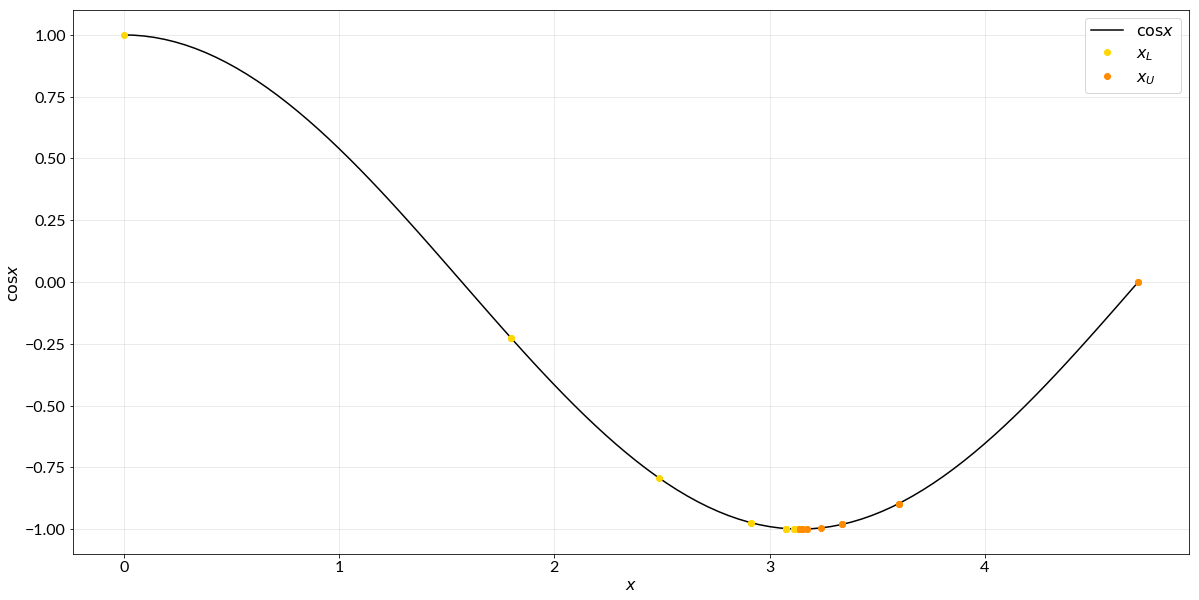

In [9]:
plt.plot(t, func(t), color='black', label=r'$\cos x$')
plt.plot(pts['x_l'], func(pts['x_l']), marker='o', linestyle='', color='gold', label=r'$x_L$')
plt.plot(pts['x_u'], func(pts['x_u']), marker='o', linestyle='', color='darkorange', label=r'$x_U$')
plt.grid(alpha=0.3)
plt.xlabel(r'$x$')
plt.ylabel(r'$\cos x$')
plt.legend()
plt.show()

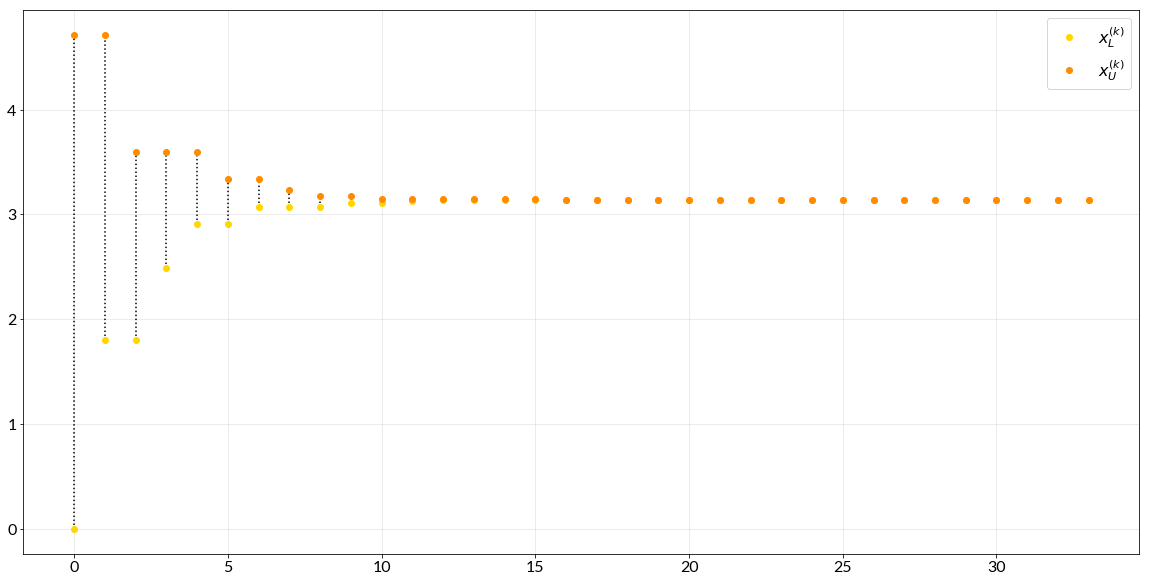

In [38]:
plt.plot(pts['x_l'], 'o', color='gold', label=r'$x_L^{(k)}$')
plt.plot(pts['x_u'], 'o', color='darkorange', label=r'$x_U^{(k)}$')
plt.vlines(x=np.arange(len(pts['x_l'])), ymin=pts['x_l'], ymax=pts['x_u'], color='k', linestyle=':')
plt.grid(alpha=0.3)
plt.legend();
plt.show();

---
### 1. Newton's method with golden section search
Implementation based on *Practical Optimization* A. Antoniou, W. S. Lu (page 130)

---

Before we implement the Newton's method we have to create to additional function. One for finding gradient and second for finind Hessian matrix for a specific value of $x$.

Both of those functions will generate a n-dimensional neighbourhood of the given point, evaluate numericaly first or second derivatives on this neighbourhood (using [`numpy.gradient`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.gradient.html) function, so second order central differences) and then compute the gradient vector or Hessian matrix for provided value.

In [7]:
def gradient_at_point(func, x, eps=0.001):
    """
    Generates a n-dimensional neighbourhood for a given point, calculates gradient of function
    `func` there and returns gradient at point `x`.
    Optional paramteters:
    `eps` side of the n-dimensional cube used as neighbourhood.
    """
    # Generating the neighbourhood
    N_NEIGHBOURHOOD_PTS = 5
    intervals = []
    for xi in x:
        intervals.append(np.linspace(xi - eps / 2, xi + eps / 2, N_NEIGHBOURHOOD_PTS))
    # Generating meshgrids
    meshes = np.meshgrid(*intervals, indexing='ij')
    # Calculating values of the function in the neighbourhood
    func_vals = np.empty(meshes[0].shape)
    for index in np.ndindex(*meshes[0].shape):
        func_vals[index] = func(*[mesh[index] for mesh in meshes])
    # Calculating the gradients in the neighbourhood
    neighbourhood_gradients = np.gradient(func_vals, *intervals)
    # Obtaining gradient at the x_k point (middle of the neighbourhood)
    gradient = np.empty(x.shape)
    for i, neighbourhood_grad in enumerate(neighbourhood_gradients):
        gradient[i] = neighbourhood_grad[tuple(N_NEIGHBOURHOOD_PTS // 2 for _ in neighbourhood_grad.shape)]
    return gradient

We will check, if the gradient is calculated properly for two simple functions:

In [8]:
def func(x, y, z):
    return x ** 2 + 2 * y + z
x0 = np.array([1, 2, 3])
print(gradient_at_point(func, x0))
print(gradient_at_point(lambda x, y: x + y, np.array([0, 0])))

[2. 2. 1.]
[1. 1.]


In [9]:
def hessian_at_point(func, x, eps=0.001):
    """
    Generates a n-dimensional neighbourhood for a given point, calculates Hessian of function
    `func` there and returns Hessian at point `x`.
    `eps` side of the n-dimensional cube used as neighbourhood.
    """
    # Generating the neighbourhood
    N_NEIGHBOURHOOD_PTS = 5
    intervals = []
    for xi in x:
        intervals.append(np.linspace(xi - eps / 2, xi + eps / 2, N_NEIGHBOURHOOD_PTS))
    # Generating meshgrids
    meshes = np.meshgrid(*intervals, indexing='ij')
    # Calculating values of the function in the neighbourhood
    func_vals = np.empty(meshes[0].shape)
    for index in np.ndindex(*meshes[0].shape):
        func_vals[index] = func(*[mesh[index] for mesh in meshes])
    # Calculating the gradients in the neighbourhood
    neighbourhood_gradients = np.gradient(func_vals, *intervals)
    # Generating Hessian for each gradient and extracting the middle-point value
    hessian = np.empty((len(x), len(x)))
    for i, outer_grad in enumerate(neighbourhood_gradients):
        for j, inner_grad in enumerate(np.gradient(outer_grad, *intervals)):
            hessian[i, j] = inner_grad[tuple(N_NEIGHBOURHOOD_PTS // 2 for _ in outer_grad.shape)]
    return hessian

As before we check the function. As we can see some numerical errors start to emerge.

In [10]:
def func(x, y, z):
    return x ** 2 + 2 * y + z
x0 = np.array([1, 2, 3])

print(hessian_at_point(func, x0))
print(hessian_at_point(lambda x, y: x ** 2 + y ** 2, np.array([1, 1])))

[[ 2.00000001e+00  3.63752406e-09  0.00000000e+00]
 [ 7.27641236e-09  1.09134817e-08 -7.27595761e-09]
 [ 0.00000000e+00 -7.27618499e-09  7.27595761e-09]]
[[2.00000000e+00 9.09494702e-10]
 [9.09494702e-10 2.00000000e+00]]


Now we can proceed to the Newton's method:

In [11]:
def newtons_method(func, x0, err=10 ** (-6), return_iter=False):
    # Inital values
    k = 0
    xs = [x0, ]
    gradients = [gradient_at_point(func, xs[-1]), ]
    hessians = [hessian_at_point(func, xs[-1]), ]
    ds = [ - np.linalg.inv(hessians[-1]) @ gradients[-1], ]
    alphas = []
    alpha, _ = golden_section_search(lambda a: func(*(xs[-1] + a * ds[-1])), 0, 1)
    alphas.append(alpha)
    xs.append(xs[-1] + alphas[-1] * ds[-1])
    # Main loop
    while True:
        # Stopping criterion
        if np.linalg.norm(alphas[-1] * ds[-1]) < err:
            if return_iter:
                return xs[-1], func(*xs[-1]), k
            return xs[-1], func(*xs[-1])
        gradients.append(gradient_at_point(func, xs[-1]))
        hessians.append(hessian_at_point(func, xs[-1]))
        ds.append( - np.linalg.inv(hessians[-1]) @ gradients[-1])
        alpha, _ = golden_section_search(lambda a: func(*(xs[-1] + a * ds[-1])), 0, 1)
        alphas.append(alpha)
        xs.append(xs[-1] + alphas[-1] * ds[-1])
        k += 1

And we check if it work for some obvious functions (shifted paraboloid)

In [12]:
def func(x, y, z):
    return x ** 2 + (y - 3) ** 2 + (z + 2) ** 2
x0 = np.array([1, 2, 3])

x_opt, f_opt = newtons_method(func, x0)
print(f"Found minimum is at {x_opt} with a value of {f_opt}")

Found minimum is at [ 1.24255452e-14  3.00000000e+00 -2.00000000e+00] with a value of 3.8845229642028445e-27


In [15]:
def func(x, y, z):
#     return x ** 2 + (y - 3) ** 2 + (z + 2) ** 2
    return np.exp(-0.5 * (x ** 2 + y ** 2 + z ** 2))

x0 = np.array([1, 2, 3])
newtons_method(func, x0)

C:\Users\kboch\Miniconda3\envs\networks\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in matmul


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

Everything works!

---
### 2. Conjugate gradient (Fletcher-Reeves)  with golden section search
Implementation based on *Practical Optimization* A. Antoniou, W. S. Lu (page 159)

---

In [ ]:
def fletcher_reeves_method(func, x0, err=10 ** (-6), n=10, return_iter=False, iteration_number=0):
    # Initial values
    k = 0
    xs = [x0, ]
    gradients = [gradient_at_point(func, xs[-1]), ]
    ds = [ - gradients[-1], ]
    alphas = []
    betas = []
    # Main loop
    while True:
        alpha, _ = golden_section_search(lambda a: func(*(xs[-1] + a * ds[-1])), -10, 10)
        alphas.append(alpha)
        xs.append(xs[-1] + alphas[-1] * ds[-1])
        # Stopin criterion
        if np.linalg.norm(alphas[-1] * ds[-1]) < err:
            if return_iter:
                return xs[-1], func(*xs[-1]), iteration_number
            return xs[-1], func(*xs[-1])
        # Re-initialization
        if k == n - 1:
            return fletcher_reeves_method(func, xs[-1], err=err, n=n, return_iter=return_iter, 
                                          iteration_number=iteration_number)
        gradients.append(gradient_at_point(func, xs[-1]))
        betas.append((gradients[-1].T @ gradients[-1]) / (gradients[-2].T @ gradients[-2]))
        ds.append( - gradients[-1] + betas[-1] * ds[-1])
        k += 1 
        iteration_number += 1

We check it on the same function as before:

In [ ]:
def func(x, y, z):
    return x ** 2 + (y - 3) ** 2 + (z + 2) ** 2
x0 = np.array([1, 2, 3])

x_opt, f_opt = fletcher_reeves_method(func, x0)
print(f"Found minimum is at {x_opt} with a value of {f_opt}")

And we obtain other appropriate result!

---
### The Rosenbrock function.
---

We define the Rosenbrock function:

In [ ]:
def rosenbrock(x1, x2):
    return 100 * (x2 - x1 ** 2) ** 2 + (1 - x1) ** 2

And plot it on a $[-2, 2] \times [-1, 2]$ rectangle.

In [ ]:
x1s = np.linspace(-2, 2)
x2s = np.linspace(-1, 2)

In [ ]:
rosenbrock_vals = np.empty(shape=(len(x1s), len(x2s)))
for i, x1 in enumerate(x1s):
    for j, x2 in enumerate(x2s):
        rosenbrock_vals[i, j] = rosenbrock(x1, x2)

In [ ]:
x, y = np.meshgrid(x1s, x2s)
fig = plt.figure()
ax = fig.gca(projection='3d')
surface = ax.plot_surface(x, y, rosenbrock_vals, cmap=matplotlib.cm.Spectral)
fig.colorbar(surface, shrink=0.8, aspect=15)
ax.set_xlabel(r'$ x_1 $')
ax.set_ylabel(r'$ x_2 $')
ax.set_zlabel(r'$ 100(x_2 - x_1^2)^2 + (1 - x_1)^2 $')
plt.show()

For those parameters the Rosenbrock function should have a minimum at the point $(1, 1)$ with a value of $0$.

We will check if previously defined algorithms reach that minimum. Our starting point would be $(0, 2)$ (but it could be any other).

In [ ]:
x0 = np.array([0, 2])

In [ ]:
x_opt, f_opt = newtons_method(rosenbrock, x0)
print(f"Found minimum is at {x_opt} with a value of {f_opt}")

In [ ]:
x_opt, f_opt = fletcher_reeves_method(rosenbrock, x0)
print(f"Found minimum is at {x_opt} with a value of {f_opt}")

---
### Speed of convergence in terms of number of iterations.
---

In [ ]:
eps = np.logspace(-8, -2, num=50)
n_iter_netwon = []
n_iter_fr = []
for e in eps:
    x_opt1, f_opt1, k_newton = newtons_method(rosenbrock, x0, err=e, return_iter=True)
    x_opt2, f_opt2, k_fr = fletcher_reeves_method(rosenbrock, x0, err=e, return_iter=True)
    n_iter_netwon.append(k_newton)
    n_iter_fr.append(k_fr)

In [ ]:
plt.plot(eps, n_iter_netwon, color='red', label='Newton\'s')
plt.plot(eps, n_iter_fr, color='green', label='Fletcher-Reeves')
plt.xlabel('Acceptable error')
plt.ylabel('Number of iterations')
plt.gca().set_xscale('log')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

---
### Speed of convergence in terms of time.
---

In [ ]:
eps = np.logspace(-8, -2, num=50)
time_newton = []
time_fr = []
for e in tqdm(eps):
    time_newton.append(timeit.timeit(lambda : newtons_method(rosenbrock, x0, err=e), number=100))
    time_fr.append(timeit.timeit(lambda : fletcher_reeves_method(rosenbrock, x0, err=e), number=100))

In [ ]:
plt.plot(eps, time_newton, color='red', label='Newton\'s')
plt.plot(eps, time_fr, color='green', label='Fletcher-Reeves')
plt.xlabel('Acceptable error')
plt.ylabel('Time [seconds] (100 repetitions)')
plt.gca().set_xscale('log')
plt.grid(alpha=0.3)
plt.legend()
plt.show()